In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.preprocessing import image
from keras.optimizers import Nadam
from keras.utils.np_utils import to_categorical
from matplotlib import pyplot as plt
from PIL import Image
from sklearn.metrics import confusion_matrix
import itertools


Using TensorFlow backend.


In [2]:

vgg_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((1,1,3))
def vgg_preprocess(x):
    x = x - vgg_mean
    return x[:, ::-1] # reverse axis rgb->bgr

def ConvBlock(model, layers, filters):
    for i in range(layers):
        model.add(ZeroPadding2D((1, 1)))
        model.add(Conv2D(filters, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
def FCBlock(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    
def BuildVGG():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(224,224,3)))
    ConvBlock(model, 2, 64)
    ConvBlock(model, 2, 128)
    ConvBlock(model, 3, 256)
    ConvBlock(model, 3, 512)
    ConvBlock(model, 3, 512)

    model.add(Flatten(name='flatten'))
    FCBlock(model)
    FCBlock(model)
    model.add(Dense(1000, activation='softmax'))

    model.load_weights('/data/trained_models/vgg16_tf.h5')
    model.compile(optimizer=Nadam(lr=0.001),loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [3]:
model = BuildVGG()

In [4]:
valid_batches = image.ImageDataGenerator().flow_from_directory(
    '/data/imdb_faces/imdb_gender/sample/valid', 
    target_size=(224,224),
    class_mode='binary', 
    shuffle=False, 
    batch_size=16
)

train_batches = image.ImageDataGenerator().flow_from_directory(
    '/data/imdb_faces/imdb_gender/sample/train', 
    target_size=(224,224),
    class_mode='binary', 
    shuffle=False, 
    batch_size=32
)

Found 2000 images belonging to 2 classes.
Found 14999 images belonging to 2 classes.


# Pre-train

In [5]:
# find the index of the flatten layer
original_layers = model.layers
flatten = [x for x in original_layers if x.name == 'flatten'][0]
flatten_idx = original_layers.index(flatten)

In [6]:
conv_layers = original_layers[:flatten_idx+1]
fc_layers = original_layers[flatten_idx+1:]

In [7]:
conv_model = Sequential(conv_layers)

In [ ]:
valid_features = conv_model.predict_generator(valid_batches, valid_batches.samples/32)
train_features = conv_model.predict_generator(train_batches, train_batches.samples/32)

In [9]:
import bcolz

In [ ]:
c = bcolz.carray(valid_features,rootdir='/data/imdb_faces/imdb_gender/sample/precalc_conv_layers_valid.bc', mode='w')
c.flush()
c = bcolz.carray(train_features,rootdir='/data/imdb_faces/imdb_gender/sample/precalc_conv_layers_train.bc', mode='w')
c.flush()

In [10]:
valid_features = bcolz.open('/data/imdb_faces/imdb_gender/sample/precalc_conv_layers_valid.bc')[:]
train_features = bcolz.open('/data/imdb_faces/imdb_gender/sample/precalc_conv_layers_train.bc')[:]

In [11]:
fc_model = Sequential([
    Dense(4096, input_shape=(25088,), activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(4096, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid'),
])

fc_model.compile(optimizer=Nadam(), loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
result = fc_model.fit(
    train_features, 
    train_batches.classes, 
    validation_data=(valid_features, valid_batches.classes),
    epochs=2
)

Train on 14999 samples, validate on 2000 samples
Epoch 1/2
14999/14999 [==============================] - ETA: 0s - loss: 1.1497 - acc: 0.6016 - val_loss: 0.7252 - val_acc: 0.6095
Epoch 2/2
14999/14999 [==============================] - ETA: 0s - loss: 0.7028 - acc: 0.6722 - val_loss: 0.9292 - val_acc: 0.6195


# Full train

In [13]:
# Build new model
cd_model = BuildVGG()
cd_model.pop()
cd_model.pop()
cd_model.pop()
cd_model.pop()
cd_model.pop()
cd_model.add(Dense(4096, activation='relu'))
cd_model.add(BatchNormalization())
cd_model.add(Dropout(0.3))
cd_model.add(Dense(4096, activation='relu'))
cd_model.add(BatchNormalization())
cd_model.add(Dropout(0.3))
cd_model.add(Dense(1, activation='sigmoid'))
cd_model.compile(optimizer=Nadam(lr=0.00001),loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
# Transfer weights
for i in range(7):
    cd_model.layers[-(1+i)].set_weights(fc_model.layers[-(i+1)].get_weights())

In [15]:
cd_model.save_weights('/data/trained_models/gender_detection_v1.h5')

In [16]:
train_batches_complete = image.ImageDataGenerator().flow_from_directory(
    '/data/imdb_faces/imdb_gender/train', 
    target_size=(224,224),
    class_mode='binary', 
    shuffle=True, 
    batch_size=16
)

Found 127044 images belonging to 2 classes.


In [17]:
result = cd_model.fit_generator(
    train_batches_complete,
    3900,
    validation_data=valid_batches,
    validation_steps=32,
    epochs=1
)

Epoch 1/1
3900/3900 [==============================] - ETA: 0s - loss: 0.6412 - acc: 0.6488 - val_loss: 1.0621 - val_acc: 0.2734


In [18]:
cd_model.save_weights('/data/trained_models/gender_detection_v2.h5')

# Examine model

In [21]:
valid_batches = image.ImageDataGenerator().flow_from_directory(
    '/data/imdb_faces/imdb_gender/valid',
    target_size=(224,224),
    class_mode='categorical', 
    shuffle=False, 
    batch_size=32
)
valid_preds = cd_model.predict_generator(valid_batches, valid_batches.samples/32)

Found 10000 images belonging to 2 classes.


In [53]:
preds = np.around(valid_preds)[:,0]
valid_labels = valid_batches.classes

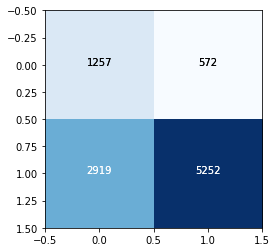

In [31]:
cm = confusion_matrix(preds,valid_labels)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2 else "black")
plt.show()

In [35]:
from numpy.random import permutation

In [55]:
incorrect = np.where(preds!=valid_labels)[0]

In [59]:
len(incorrect)

3491

In [68]:
img = Image.open('/data/imdb_faces/imdb_gender/valid/' + valid_batches.filenames[incorrect[345]])

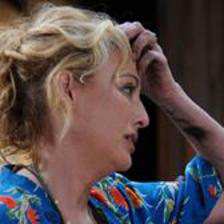

In [69]:
img